In [7]:
%matplotlib inline
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "minst"

PATH.mkdir(parents=True, exist_ok=True)
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)


In [14]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')



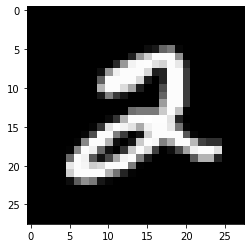

In [9]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[5].reshape((28, 28)), cmap="gray")


In [15]:
import torch
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [16]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
from torch.utils.data import TensorDataset
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)

In [21]:
from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2)
    )

In [48]:
dev = torch.device("cuda")

In [49]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

In [52]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        super().__init__()
        self.dl = dl
        self.func = func
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [53]:
bs = 128
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [28]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)


In [50]:
from torch.nn import Sequential
from torch import optim

model = Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
).to(dev)
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [35]:
import torch.nn.functional as F

loss_func = F.cross_entropy

In [39]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [56]:
def fit(epochs, model, loss_func, train_dl, valid_dl, opt):
    for epoch in range(epochs):
        model.train()
        losses, nums = zip(
            *[loss_batch(model, loss_func, xb, yb, opt)
              for xb, yb in train_dl]
        )
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb)
                  for xb, yb in valid_dl]
            )
        valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, train_loss, valid_loss)
    
epochs = 10
fit(epochs, model, loss_func, train_dl, valid_dl, opt)

            

0 0.14462410852909088 0.1429478087425232
1 0.142223822658062 0.16383531351089478
2 0.13628388669490815 0.1585684856414795
3 0.13454443618297576 0.13793596000671388
4 0.12783997813344003 0.1322885805130005
5 0.12389013313055039 0.13208367671966553
6 0.11932706804513932 0.13960241832733156
7 0.11858695472598076 0.1256098334312439
8 0.11630805201053619 0.12670463676452637
9 0.11243605055809021 0.12940022897720338
